In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation

In [2]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

despine_offset = 0
despine_trim = True

### Load data and create functions to show the sample RT profiles between treated and untreated pseudoublks for the TNBC PDXs

In [3]:
def read_rt_data(datasets):
    # read in the pseudobulk RT profiles for each sample
    rt = pd.DataFrame()
    path = 'scdna_replication_paper/analysis/fitness/{}/scRT_pseudobulks.tsv'
    for d in datasets:
        temp_rt = pd.read_csv(path.format(d), sep='\t')
        cols = [c for c in temp_rt.columns if c.startswith('pseudobulk') and ('hours' not in c)]
        cols.append('chr')
        cols.append('start')
        temp_rt = temp_rt[cols]
        
        for c in temp_rt.columns:
            if c.startswith('pseudobulk') and ('hours' not in c):
                temp_rt.rename(columns={c: '{}_{}'.format(d, c)}, inplace=True)
        
        if rt.empty:
            rt = temp_rt
        else:
            rt = pd.merge(rt, temp_rt)

    # set chr column to category
    rt.chr = rt.chr.astype('str').astype('category')

    # add end position as it's necessary for plotting functions
    rt['end'] = rt['start'] + 500000 - 1

    return rt

In [4]:
datasets = ['SA1035', 'SA535', 'SA609']
rt = read_rt_data(datasets)

# create a list of the treated vs untreated rt profiles
rx_rt_cols = [c for c in rt.columns if c.endswith('model_rep_state_T') or c.endswith('model_rep_state_U')]

In [38]:
def plot_rx_corrs(rt, clone_rt_cols, ax):
    ''' Plot the correlation between treated and untreated RT profiles. '''
    # correlation between RT profiles
    rt_corrs = rt[clone_rt_cols].corr()
    mask = np.zeros_like(rt_corrs, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    cbar_kws = {
        "shrink": .5, "label": "Pearson r", 
        # "anchor": (-1.0, 2.0), "orientation": "horizontal"
    }
    sns.heatmap(rt_corrs, square=False, linewidths=.5, cbar_kws=cbar_kws, mask=mask, annot=True, fmt='.2f', ax=ax, cmap='Blues')
    ax.set_title('Treated vs untreated RT correlation')

    # only include the sample ID prefix and the T or U suffix in the xticklabels and yticklabels
    ax.set_xticklabels(['{} {}'.format(str(c.get_text()).split('_')[0], str(c.get_text()).split('_')[-1]) for c in ax.get_xticklabels()])
    ax.set_yticklabels(['{} {}'.format(str(c.get_text()).split('_')[0], str(c.get_text()).split('_')[-1]) for c in ax.get_yticklabels()])


### Load data that shows the distribution of S-phase cell times (fraction of replicated bins) for each treated and untreated samples of TNBC PDXs

In [18]:
# load fraction of replicated bins per cell across all TNBC PDXs
def load_cohort_s_time_data(datasets):
    """ Read in the scRT for each data cohort, only keeping the relevant per-cell columns. """
    df = []

    # loop through the input files
    for d in datasets:
        path = 'scdna_replication_paper/analysis/fitness/{}/s_phase_cells_with_scRT_filtered.tsv'.format(d)
        # read in the tsv
        temp_df = pd.read_csv(path, sep='\t')
        # add the dataset name as a column
        temp_df['dataset'] = d
        # keep only the relevant columns
        temp_df = temp_df[['dataset', 'label', 'datasetname', 'cell_id', 'library_id', 'clone_id', 'cell_frac_rep', 'model_tau']].drop_duplicates().reset_index(drop=True)
        # add a 'cisplatin' column that is False if a 'U' appears in the datasetname of the cell, True otherwise
        temp_df['cisplatin'] = temp_df['datasetname'].apply(lambda x: 'untreated' if 'U' in x else 'treated')
        
        # append to the list
        df.append(temp_df)
    
    # concatenate the list of dataframes into one
    df = pd.concat(df, ignore_index=True)

    return df

In [19]:
df_s_time = load_cohort_s_time_data(datasets)

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (22,27,33) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


In [50]:
def get_rx_cmap():
    cmap = {
        'Rx-': '#CCCCCC', # grey
        'U': '#CCCCCC',
        'untreated': '#CCCCCC',
        'Rx+': 'C0',
        'T': 'C0',
        'treated': 'C0'
    }
    return cmap

def violinplot_with_pvals(df, x, y, hue, ax, box_pairs, order=None, test='t-test_ind', text_format='star', loc='inside', verbose=0, palette=None):
    sns.boxplot(data=df, x=x, y=y, hue=hue, ax=ax, order=order, palette=palette, linewidth=0.5, fliersize=1)
    add_stat_annotation(ax, data=df, x=x, y=y, hue=hue,
                        box_pairs=box_pairs, test=test, order=order,
                        text_format=text_format, loc=loc, verbose=verbose)


def plot_rx_s_times(df, ax, x='dataset', y='cell_frac_rep', hue='cisplatin', test='t-test_ind', text_format='star', loc='inside', verbose=0):
    ''' 
    Plot the difference in pseudobulk clone S-phase fractions
    where the data is split by treatment status
    '''
    rx_cmap = get_rx_cmap()
    x = x
    y = y
    hue = hue
    box_pairs = [
        (('SA535', 'untreated'), ('SA535', 'treated')),
        (('SA1035', 'untreated'), ('SA1035', 'treated')),
        (('SA609', 'untreated'), ('SA609', 'treated'))
    ]
    violinplot_with_pvals(df, x, y, hue, ax, box_pairs, test=test,
                       text_format=text_format, loc=loc, verbose=verbose, palette=rx_cmap)
    
    # reformat the axis labels
    ax.set_ylabel('fraction of replicated bins\n<--early S| late S-->')
    ax.set_xlabel('')
    ax.set_title('S-phase times')
    ax.set_ylim(-0.05, 1.05)
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    sns.despine(ax=ax, offset=despine_offset, trim=despine_trim)
    # move the legend underneath the x-axis, make 2 columns and remove the title
    ax.legend(title='', loc='upper left', frameon=False, ncol=2, bbox_to_anchor=(0, -0.1))

### Load data to compare the fraction of S-phase cells in treated and untreated samples of TNBC PDXs

In [51]:
counts = pd.read_csv('scdna_replication_paper/analysis/fitness/cohort_rx_clone_counts.tsv', sep='\t')

# aggregate the clones by dataset and treatment status
counts = counts[['dataset', 'rx_status', 'num_cells_s', 'num_cells_g']].groupby(['dataset', 'rx_status']).agg({'num_cells_s': 'sum', 'num_cells_g': 'sum'}).reset_index()
# calculate the fraction of cells in S-phase
counts['frac_cells_s'] = counts['num_cells_s'] / (counts['num_cells_s'] + counts['num_cells_g'])
counts['frac_cells_g'] = counts['num_cells_g'] / (counts['num_cells_s'] + counts['num_cells_g'])



In [52]:
def plot_spf_by_rx(counts, ax):
    # plot the fraction of cells in S-phase for each dataset, split by treatment status
    sns.barplot(data=counts, x='dataset', y='frac_cells_s', hue='rx_status', ax=ax, palette=get_rx_cmap(), hue_order=['untreated', 'treated'])
    ax.set_ylabel('S-phase fraction')
    ax.set_xlabel('')
    ax.set_title('Sample cell cycle distributions')
    # move the legend underneath the x-axis, make 2 columns and remove the title
    ax.legend(title='', loc='upper left', frameon=False, ncol=2, bbox_to_anchor=(0, -0.1))
    # ax.legend(title='', loc='upper left', frameon=False)
    sns.despine(ax=ax, offset=0, trim=despine_trim)
    

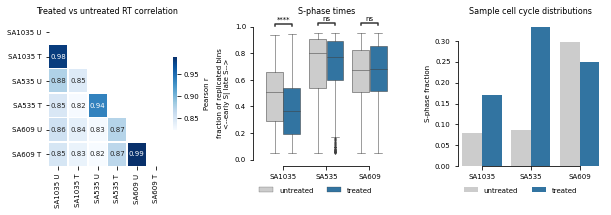

In [54]:
fig, ax = plt.subplots(1, 3, figsize=(8.5, 3), tight_layout=True)
ax = ax.flatten()

# plot the correlation between treated and untreated RT profiles
plot_rx_corrs(rt, rx_rt_cols, ax[0])

# plot the distributions of S-phase times between treated and untreated cells for each sample
plot_rx_s_times(df_s_time, ax[1])

# plot the fraction of cells in S-phase for each sample, split by treatment status
plot_spf_by_rx(counts, ax[2])

fig.savefig('scdna_replication_paper/manuscript/supplementary_figs/figS5.pdf', dpi=300, bbox_inches='tight')

plt.show()